<table align="left" style="border-style: hidden" class="table"> <tr><td class="col-md-2"><img style="float" src="http://prob140.org/assets/icon256.png" alt="Prob140 Logo" style="width: 120px;"/></td><td><div align="left"><h3 style="margin-top: 0;">Probability for Data Science</h3><h4 style="margin-top: 20px;">UC Berkeley, Fall 2019</h4><p>Ani Adhikari and Jim Pitman</p>CC BY-NC 4.0</div></td></tr></table><!-- not in pdf -->

In [1]:
# SETUP
from datascience import *
from prob140 import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pylab
from scipy import stats
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

In [2]:
def search(x_limits, cdf, u):
    """
    Runs a binary search to find the inverse cdf.
    """
    # Handle possible asymptotes.
    if cdf(x_limits[0]) > u:
        return x_limits[0]
    if cdf(x_limits[1]) < u:
        return x_limits[1]
    
    mid = (x_limits[0] + x_limits[1])/2
    diff = u - cdf(mid)
    if np.abs(diff) < 0.01:
        return mid
    if diff < 0:
        return search((x_limits[0], mid), cdf, u)
    return search((mid, x_limits[1]), cdf, u)

def plot_axes(cdf_table):
    values = cdf_table.column(cdf_table.num_columns - 1)
    cum = list(np.cumsum(values))
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    plt.yticks([0] + cum)
    plt.ylim(-0.1, 1.1)
    plt.plot([0,0], [0,1], color="k", lw=3)
    plt.xlim(-0.02, 1)
    plt.scatter([0]*(len(cum) + 1),
                [0] + cum, s=55, color="k")

def plot_discrete_cdf(cdf_table, u=None):
    """
    Plots the cdf of a discrete distribution.
    
    Parameters
    ----------
    cdf_table : Table
        Table of cdf values.
    u : float
        Value from (0, 1) to plot inverse cdf of.
    """
    values = cdf_table.column(0)
    values = np.append(values[0] - 2, values)

    cum = cdf_table.column(cdf_table.num_columns - 1)
    cum = np.append(0, np.cumsum(cum))

    for i in range(len(values) - 1):
        plt.plot([values[i], values[i+1]], [cum[i], cum[i]],
                 color="darkblue")
        plt.plot([values[i+1], values[i+1]], [cum[i], cum[i+1]],
                 ls="--", color="darkblue" )
    plt.scatter(values, cum, s=50, color="darkblue")    

    plt.plot([values[-1], values[-1] + 2], [1,1],
             color="darkblue")

    plt.xlim(values[0], values[-1] + 2)
    plt.ylim(-0.1, 1.1)
    plt.xlabel('$x$')
    plt.ylabel('CDF at $x$')
    plt.title('Graph of CDF');
    
    if u != None:
        for i in range(len(values)):
            if u <= cum[i]:
                index = values[i]
                break
        height = u
        
        plt.plot([values[0], (index+values[0])/2], [height, height],
                 marker='>', color='red', lw=1)
        plt.plot([(index+values[0])/2, index], [height, height],
                 color='red', lw=1)
        plt.plot([index, index], [height, height/2], marker="v",
                 color="red", lw=1)
        plt.plot([index, index], [0, height/2], color="red", lw=1)

def plot_continuous_cdf(x_limits, cdf, u=None):
    """
    Plots the cdf of a continuous distribution.
    """
    x = np.linspace(*x_limits, 100)
    cdf_values = list(map(cdf, x))
    plt.plot(x, cdf_values, color="darkblue")
    plt.xlabel('$x$')
    plt.ylabel('CDF at $x$')
    plt.title('Graph of CDF');
    
    if not u is None:
        index = search(x_limits, cdf, u)
        height = u

        plt.plot([x_limits[0], (index+x_limits[0])/2],
                 [height, height], marker='>', color='red', lw=1)
        plt.plot([(index+x_limits[0])/2, index],
                 [height, height], color='red', lw=1)
        plt.plot([index, index], [height, height/2],
                 marker="v", color="red", lw=1)
        plt.plot([index, index], [0, height/2], color="red", lw=1)


    plt.xlim(*x_limits)

def unit_interval_to_discrete(cdf_table):
    uniform_slider = widgets.FloatSlider(
        value=0.5,min=0,max=1,step=0.02, description='u')
    @interact(u = uniform_slider)
    def plot(u):
        plot_discrete_cdf(cdf_table, u)


def unit_interval_to_continuous(x_limits, cdf):
    uniform_slider2 = widgets.FloatSlider(
        value=0.5, min=0,max=1,step=0.02, description='u')
    
    @interact(u = uniform_slider2)
    def plot(u):
        if (cdf(u) > x_limits[1] or cdf(u) < x_limits[0]):
            plot_continuous_cdf(x_limits, cdf)
        else:
            plot_continuous_cdf(x_limits, cdf, u)
    
def override_hist(*args, **kwargs):
    """
    This cleans up some unfortunate floating point precision
    bugs in the datascience library
    """
    #kwargs['edgecolor'] = 'w'
    Table.hist2(*args, **kwargs)
    ax = plt.gca()
    ticks = ax.get_xticks()
    if np.any(np.array(ticks) != np.rint(ticks)):
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if not hasattr(Table, 'hist2'):
    Table.hist2 = Table.hist
    
Table.hist = override_hist

In [3]:
def plot_radial_distances():
    n = 500
    sampled_thetas = np.random.uniform(0, 2 * np.pi, n)
    sampled_radii = np.sqrt(np.random.uniform(0, 1, n))
    x = sampled_radii * np.cos(sampled_thetas)
    y = sampled_radii * np.sin(sampled_thetas)
    theta = np.linspace(0, 2 * np.pi, 100)
    uniform_slider = widgets.IntSlider(
        value=10,
        min=1,
        max=n,
        step=1,
        description='n'
    )
    @interact(i=uniform_slider)
    def plot(i):
        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.plot(np.cos(theta), np.sin(theta), color='gold')
        ax1.scatter(x[:i], y[:i], color='darkblue', s=10)
        ax1.set_aspect('equal')
        ax1.set_title('Simulated Points')
        ax1.set_xticks(np.arange(-1, 1.5, 0.5))
        ax1.set_yticks(np.arange(-1, 1.5, 0.5))
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.set_title('Empirical Histogram of Radius')
        ax2.hist(sampled_radii[:i], bins=np.linspace(0, 1, 25), density=True, color='darkblue')
        ax2.set_ylabel('Percent per Unit')
        plt.yticks(ax2.get_yticks(), ax2.get_yticks() * 100);
        ax2.set_xlabel('r')
        plt.subplots_adjust(wspace=0.5)

## Lab Resources

* [`prob 140` Library Documentation](http://prob140.org/prob140/)
* [Data 8 Python Reference](http://data8.org/fa18/python-reference.html)
* [Prob 140 Code Reference Sheet](http://prob140.org/assets/prob140_code_reference.pdf)
* [`scipy.stats` Documentation](https://docs.scipy.org/doc/scipy/reference/stats.html)

# Lab 7: Simulation and the CDF#

Simulation helps us understand properties of random variables. For example, earlier in the term you saw `simulate_path` for simulating Markov Chains; this was helpful for understanding transition behavior and reversibility. The `Table` method `sample` simulates drawing uniformly at random from the rows of a table; in Data 8, you used it understand the bootstrap. Simulation is also important because properties observed in simulations can lead to the development of new results. 

In this lab you will simulate random variables with specified distributions.

What you will learn:
- How to use `SciPy` for simulation
- How to construct and read graphs of cumulative distribution functions (cdfs)
- How being able to simulate just one distribution allows us to simulate all others

## Instructions
Your labs have two components: a written portion and a portion that also involves code. Written work should be completed on paper, and coding questions should be done in the notebook. You are welcome to LaTeX your answers to the written portions, but staff will not be able to assist you with LaTeX related issues. It is your responsibility to ensure that both components of the lab are submitted completely and properly to Gradescope. Refer to the bottom of the notebook for submission instructions.

#newpage

## Part 1: Simulation in SciPy ##
The `stats` module of `SciPy` is familiar to you by now. For any of the well known distributions, you can use `stats` to simulate values of a random variable with that distribution. The general call is `stats.distribution_name.rvs(size = n)` where `rvs` stands for "random variates" and `n` is the number of independent replications you want. 

Every statistical system has conventions for how to specify the parameters of a distribution. In this lab we will tell you the specifications for a few distributions. Later you will be able to see a general pattern in the specifications.

### 1a) Uniform $(0, 1)$ ###
The call is straightforward: `stats.uniform.rvs(0, 1, size=n)`. Complete the cell below to draw the histogram of 100,000 simulated values of a random variable that has the uniform $(0, 1)$ distribution. The `hist` option `bins=25` results in 25 equal bins.

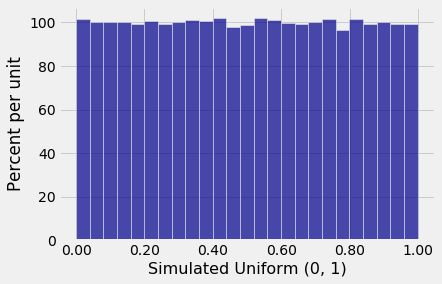

In [4]:
sim_uniform = stats.uniform.rvs(0, 1, size=100000)
sim_uniform_tbl = Table().with_column(
    'Simulated Uniform (0, 1)', sim_uniform
)
sim_uniform_tbl.hist(bins=25)

### 1b) Reading the Scales of the Histogram ###
The unit on the horizontal axis is any unit of length; you can think of it as centimeters if you want, but we will just refer to it as the "unit". Fill in the blanks below and provide units where appropriate. Some units have been provided for you.

(i) The width of each bin is $\underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$ units.

(ii) The height of each bar is approximately $\underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$ per $\underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$.

(iii) Histograms represent percents by $\underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$, so the answers to (i) and (ii) imply that the percent of simulated values in each bin is approximately $\underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$%.

(iv) Let the random variable $U$ have the uniform $(0, 1)$ distribution, and let $B$ be any bin of the histogram. The answer to (i) implies that $P(U \in B) = \underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$%.

(v) If instead of `bins=25` we had used `bins=20` as the option to `hist`, then the answer to (iv) would have been $\underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$%

(i) 0.04 Units

(ii) 100 percent, unit

(iii) area, 0.04

(iv) 4

(v) 5

### 1c) Exponential ###
The exponential distribution has two common parametrizations. One is the rate $\lambda$, which is what we use in Prob 140. The other is the mean $\frac{1}{\lambda}$. The mean is called the `scale` parameter in `stats`. Complete the cell below to simulate 100,000 values of a random variable that has the exponential distribution with rate $0.5$.

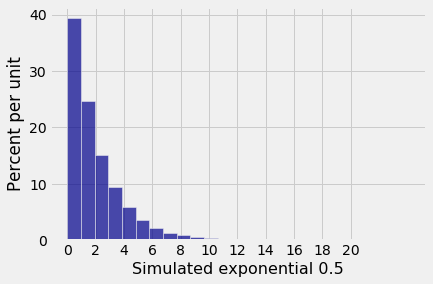

In [18]:
sim_expon =   stats.expon.rvs(scale = 2, size=100000)               # array of simulated values
sim_expon_tbl = Table().with_column(
    'Simulated exponential 0.5', sim_expon
)
sim_expon_tbl.hist(bins=25)
plt.xticks(np.arange(0, 21, 2));

Find the average of the simulated values and check that it is consistent with the rate.

In [19]:
np.mean(sim_expon_tbl[0])

2.0079186640838826

#newpage

## Part 2. The Idea ##
How are all these random numbers generated? In the rest of the lab we will develop the method that underlies all the simulations above, by considering examples of increasing complexity. 

Our starting point is a distribution on just four values. 

Suppose $X$ has the distribution `dist_X` below. 

In [20]:
vals_X = make_array(-2, 1, 4, 7)
probs_X = make_array(0.3, 0.1, 0.2,0.4)

dist_X = Table().values(vals_X).probabilities(probs_X)
dist_X

Value,Probability
-2,0.3
1,0.1
4,0.2
7,0.4


Our goal is to simulate one value of $X$. That is, we want to come up with a process that returns one of the four possible values of $X$ with the right probabilities.

### 2a) A Vertical Unit Interval ###
The graphic below shows the probabilities in `dist_X` stacked vertically as in Lab 4. From the bottom to the top, therefore, you have the unit interval.

Now imagine throwing a dart at the unit interval. That is, let $U$ be a random variable that has the uniform distribution on $(0, 1)$, and suppose you mark the value of $U$ on the unit interval shown in the graph.

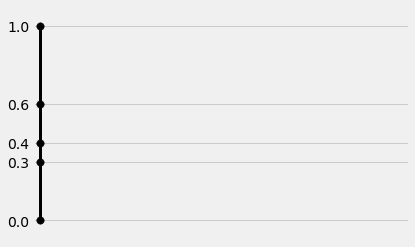

In [14]:
plot_axes(dist_X)

Find the following probabilities and see how they are related to the distribution of $X$.

(i) $P(U \le 0.3)$

(ii) $P(0.3 < U \le 0.4)$

(iii) $P(0.4 < U \le 0.6)$

(iv) $P(0.6 < U \le 1)$


(i) $P(U \le 0.3) = 0.3$

(ii) $P(0.3 < U \le 0.4) = 0.1$

(iii) $P(0.4 < U \le 0.6) = 0.2$

(iv) $P(0.6 < U \le 1) = 0.4$

### 2b) Idea for Simulating $X$ ###
Starting with a uniform $(0, 1)$ random variable $U$, propose a method of generating a value of $X$. 

Your method should take $U$ as its input and return one of the four possible values as output, in such a way that for each $i = -2, 1, 4, 7$, the chance of returning the value $i$ is $P(X = i)$.

Just describe your method in words. No formula or code is needed.

The values of U will determine the value of i such that:
0 $\leq$ U $\leq$ 0.3 then the method returns -2

0.3 $<$ U $\leq$ 0.4 then it will return 1

0.4 $<$ U $\leq$ 0.6 then it will return 4

0.6 $<$ U $\leq$ 1 then it will return 7

#newpage

## Part 3. Visualizing the Idea ##
The method `plot_discrete_cdf` takes a distribution as its argument and plots a graph of the cdf.

Run the cell below to get a graph of the cdf of the random variable $X$ in Part 1.

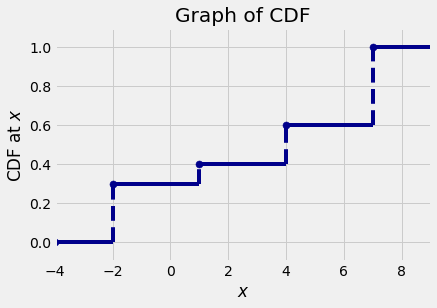

In [21]:
plot_discrete_cdf(dist_X)

### 3a) Reading the Graph ###
Let $F_X$ be the cdf of $X$. What is the definition of $F_X(2.57)$? Does the graph show the correct value for $F_X(2.57)$?

The definition of $F_X(2.57)$ is the probability P(-$\infty$ < X $\leq$ 2.57), where X can take any values from negative infinity to 2.57. The graph shows the correct value, since the probability of X being less then or equal to 2.57 is just P(X = -1)+P(X = 1)= 0.3+0.4 since these are the only possible values of X that are less then or equal to 2.57.

### 3b) Jumps ###
At what points $x$ does the graph have a jump? For each point $x$ at which there is a jump, find the size of the jump in terms of the distribution of $X$.

The graph has a jump at points -2, 1, 4, and 7 and the size of the jump in terms of the distribution is just the probability of X at the value so for the jump at -2, the size of the jump is just P(X = -2) = 0.3

### 3c) From the Unit Interval to Values of $X$ ###
The function `unit_interval_to_discrete` takes a distribution as its argument and displays an animation of a method that generates one value of a random variable that has the given distribution.  The method starts with a number on the unit interval.

Run the cell below. Move the slider around and see how the returned value changes **depending on the starting value** in the unit interval. How is the method that is being displayed related to the one you proposed in Part 1?

In [22]:
unit_interval_to_discrete(dist_X)

interactive(children=(FloatSlider(value=0.5, description='u', max=1.0, step=0.02), Output()), _dom_classes=('w…

The method that is being displayed is related exactly to the method proposed in Part 2 (not Part 1, this might be a typo?). We can see that when U is between 0 and 0.3, the value of X is -2, when U is above 0.3 and below or equal to 0.4 then X is 1, etc. It follows the exact inequalities of U that we defined in Part 2.

### 3d) A Random Starting Point ###
The method `plot_discrete_cdf` that you used earlier also takes a second argument which is a number between 0 and 1. 

Complete the cell below so that the second argument is picked uniformly at random from (0, 1). Run the cell a few times. How is it related to the method you proposed in Part 1 for generating a value of $X$?

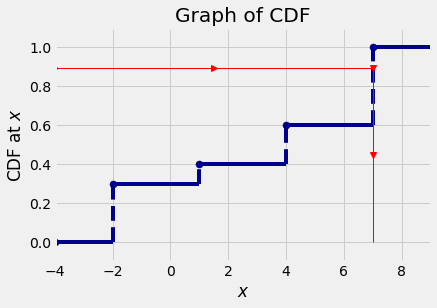

In [47]:
U = stats.uniform.rvs(size = 1)
plot_discrete_cdf(dist_X, u = U)

This is related to the method we proposed above as it is essentially sampling the distribution, albeit only for one value of U at a time. Ultimately, this is a visualization of how a sample of size 1 would be simulated using the method proposed in part 2.

#newpage

## Part 4. Extension to Continuous Distributions ##
Now suppose you want to generate a random variable that has a specified continuous distribution. Let's start with the exponential $(\lambda)$ distribution.

### 4a) [ON PAPER] Exponential CDF ###
Let $T$ have the exponential distribution with rate $\lambda$. Let $F_T$ be the cdf of $T$. Write the formula for $F_T$. Remember that the cdf is a function on the entire number line $(-\infty, \infty)$; make sure you specify the function on the whole line. 

### 4b) Plotting the Exponential CDF ###
As a numerical example, let $T$ be a random variable that has the exponential distribution with rate $\lambda = 0.5$, or equivalently, expectation $2$. Define a function `expon_mean2_cdf` that takes a numerical argument $x$ and returns $F_T(x)$. Use `np.exp(y)` for $e^y$.

Make sure that for **all** numerical values of $x$ your function returns the value you specified in **4a**.

In [51]:
# don't use "lambda" as that means something else in Python
lamb = 0.5

def expon_mean2_cdf(x):
    return 1 - np.exp(-lamb*x)

The function `plot_continuous_cdf` plots the cdf of a continuous variable. The first two arguments:
- an interval (a, b) over which to draw the cdf
- the name of a cdf function that takes a numerical input and returns the value of the cdf at that input

Run the cell below to check that your function `expon_mean2_cdf` looks good.

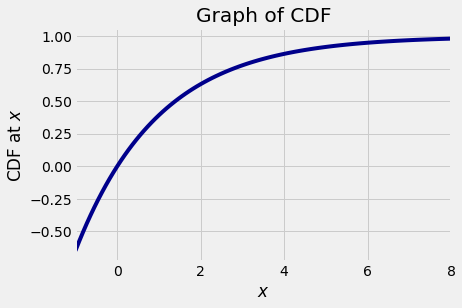

In [52]:
plot_continuous_cdf((-1, 8), expon_mean2_cdf)

### 4c) Idea for Simulating an Exponential Random Variable ###

Suppose you are given one uniform $(0, 1)$ random number and are asked to simulate $T$. Based on Part 3 of the lab, propose a method for doing this by using the graph above.

You don't have to prove that the method works. We'll do a formal proof in lecture. Just propose the method.

Based on part 3, the method we can use to simulate T using a random number, U, from uniform distribution (0,1) is that we take the value of U, and match it to the X value that has the same 'CDF at X' value. This X value will be the value of the simulated variable T. For example, if the value of U is 0, we return 0 as the simulated T value since the CDF of the X value 0 is also 0.

### 4d) Visualizing the Idea ###
The animation in the cell below is analogous to the one in Part 3. Its arguments are: 
- a plotting interval
- the name of a continuous cdf function

The output demonstrates a method for picking a number on the positive real line starting with a value on the unit interval that forms the vertical axis. 

Run the cell and move the slider around to see how the returned value changes depending on the starting value on the vertical axis.

In [53]:
unit_interval_to_continuous((-1, 8), expon_mean2_cdf)

interactive(children=(FloatSlider(value=0.5, description='u', max=1.0, step=0.02), Output()), _dom_classes=('w…

The method `plot_continuous_cdf` takes an optional third argument that is a number between $0$ and $1$. 

Complete the cell below so that the third argument is a random number picked uniformly from (0, 1). Run the cell a few times. How is the output related to the method you proposed in **4c** for generating a value of $T$?

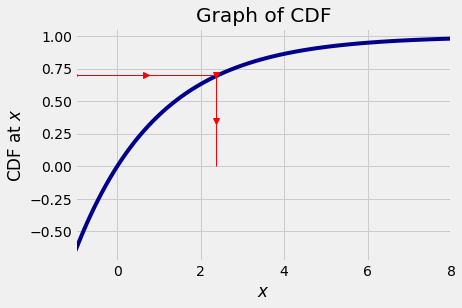

In [63]:
U = stats.uniform.rvs(size = 1)
plot_continuous_cdf((-1, 8), expon_mean2_cdf, u = U)

This output is related to the method proposed in 4c as it is a visualization of how the simulation method would work. 

### 4e) [ON PAPER] The General Method ###
Let $F$ be any continuous increasing cdf. That is, suppose $F$ has no jumps and no flat bits. 

Suppose you are trying to create a random variable $X$ that has cdf $F$, and suppose that all you have is $F$ and a number picked uniformly on $(0, 1)$.

(i) **Fill in the blank:** Let $U$ be a uniform $(0, 1)$ random variable. To construct a random variable $X = g(U)$ so that $X$ has the cdf $F$, take $g = \underline{~~~~~~~~~~~~~}$.


(ii) **Fill in the blank:** Let $U$ be a uniform $(0, 1)$ random variable. For the function $g$ defined by

$$
g(u) ~ = ~ \underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~}, ~~~ 0 < u < 1
$$

the random variable $X = g(U)$ has the exponential $(\lambda)$ distribution.

[Note: If $F$ is a discrete cdf then the function $g$ is complicated to write out formally, so we're not asking you to do that. The practical description of the method of simulation is in Parts 1 and 2.]

#newpage

## Part 5. Empirical Verification that the Method Works ##

### a) The Initial Values ###
Create a table that is called `sim` for simulation and consists of one column called `Uniform` that contains the values of 100,000 i.i.d. uniform $(0, 1)$ random variables.

In [64]:
N = 100000
u = U = stats.uniform.rvs(size = N)
sim = Table().with_column("Uniform", u)
sim

Uniform
0.642397
0.130611
0.529786
0.553471
0.386765
0.594526
0.320629
0.455995
0.535774
0.341061


### b) Tranformation to Exponential ###
Use **4e** and the values in the column `Uniform` to create an array of values that have the exponential distribution with rate $0.5$. This is what is going on "under the hood" in `stats.expon.rvs`.

**Do not** simulate new random numbers, as you will lose the connection with the values in `Uniform`. Use `np.log(y)` for $\log(y)$.

Augment `sim` with a column containing the new array.

In [80]:
def uniform_to_exponential_mean2(u):
    return -np.log(1-u)/0.5

exponential_mean2 = sim.apply(uniform_to_exponential_mean2, 'Uniform')
sim = sim.with_column('Sim. Exponential (rate 0.5)', exponential_mean2)
sim

Uniform,Sim. Exponential (rate 0.5)
0.642397,2.05666
0.130611,0.27993
0.529786,1.50914
0.553471,1.6125
0.386765,0.978014
0.594526,1.8054
0.320629,0.773177
0.455995,1.21759
0.535774,1.53477
0.341061,0.83425


Run the cell below and compare with the histogram in 1(d) to confirm that your calculation is correct.

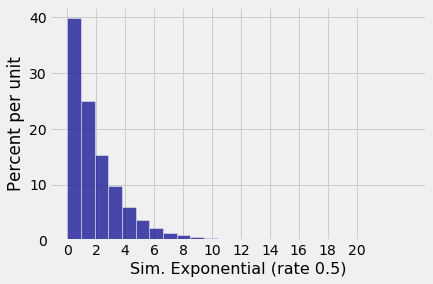

In [81]:
sim.hist('Sim. Exponential (rate 0.5)', bins=25)
plt.xticks(np.arange(0, 21, 2));

At this point, go back and look through Part 5. Notice that the only time you generated random numbers was when you simulated 100,000 uniform (0, 1) values. All the other variables were deterministic transformations of the uniform variable.

## Conclusion ##
You have learned that:
- To simulate a random variable with a desired distribution, what you need is a uniform random number generator and the cdf of the desired distribution. You can then use the method of this lab to simulate the value.
- The only random numbers a statistical system needs are uniform on (0, 1). Random numbers from all other distributions follow by the method you have developed in this lab.
- Discrete cdfs consist of jumps and flat parts, at places that you have identified.

Since uniform $(0, 1)$ random numbers are central to all simulations, their quality is very important for the accuracy and reliability of simulations. Testing and assessing uniform random number generators is serious business, because random number generators don't really produce random numbers. They follow deterministic processes that produce results that have properties that resemble those of random numbers. That is why they are called Pseudo Random Number Generators or PRNGs. [Python uses the Mersenne Twister](https://docs.python.org/3.6/library/random.html), one of the most tested and reliable PRNGs. SciPy uses the [Mersenne Twister for RandomState](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.RandomState.html) and draws from a large number of discrete and continuous distributions. Take a look at the list on the RandomState page and see how many you can recognize.

## Submission Instructions ##

Many assignments throughout the course will have a written portion and a code portion. Please follow the directions below to properly submit both portions.

### Written Portion ###
*  Scan all the pages into a PDF. You can use any scanner or a phone using an application. Please **DO NOT** simply take pictures using your phone. 
* Please start a new page for each question. If you have already written multiple questions on the same page, you can crop the image or fold your page over (the old-fashioned way). This helps expedite grading.
* It is your responsibility to check that all the work on all the scanned pages is legible.

### Code Portion ###
* Save your notebook using File > Save and Checkpoint.
* Generate a PDF file using File > Download as > PDF via LaTeX. This might take a few seconds and will automatically download a PDF version of this notebook.
    * If you have issues, please make a follow-up post on the general Lab 7 Piazza thread.
    
### Submitting ###
* Combine the PDFs from the written and code portions into one PDF.  [Here](https://smallpdf.com/merge-pdf) is a useful tool for doing so. 
* Submit the assignment to Lab 7 on Gradescope. 
* **Make sure to assign each page of your pdf to the correct question.**
* **It is your responsibility to verify that all of your work shows up in your final PDF submission.**


### **We will not grade assignments which do not have pages selected for each question.** 